In [13]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')

## 1. Theoretical Background

### Logistic Regression
Binary classification via sigmoid function that outputs probability:
$$p(y=1|x) = \sigma(z) = \frac{1}{1+e^{-z}}, \quad z = \beta_0 + \sum_{i=1}^{n} \beta_i x_i$$

**Decision Rule:** Predict class 1 if $p(y=1|x) \geq 0.5$, else class 0

**Cost Function (Log Loss):**
$$J(\beta) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(h_\beta(x^{(i)})) + (1-y^{(i)}) \log(1-h_\beta(x^{(i)}))]$$

**Regularization:** Add $\lambda \sum |\beta_j|$ (L1) or $\lambda \sum \beta_j^2$ (L2) to prevent overfitting.

### Linear Regression (Comparison)
Predicts continuous values: $\hat{y} = \beta_0 + \sum_{i=1}^{n} \beta_i x_i$

**Cost Function (OLS):** $J(\beta) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2$

**For Binary Classification:** Outputs are unbounded; can estimate probabilities but less suitable than logistic regression.

## 2. Dataset & Methodology

**Bank Marketing Dataset:**  
- 45,211 samples from Portuguese banking institution marketing campaign
- 17 features: age, job, marital status, education, balance, loans, contact type, duration, campaign count, previous contact info
- Binary target: subscribed to term deposit (yes/no)
- Class imbalance: ~88% negative, ~12% positive subscriptions

**Methodology:**
1. Load & visualize target distribution
2. Encode categorical variables (Label Encoding)
3. Standardize features (StandardScaler) - critical for logistic regression
4. Train-Test split 70-30 with stratification
5. Train both models and compare coefficients
6. Evaluate using confusion matrix, ROC-AUC, precision, recall, F1-score
7. Hyperparameter tuning: GridSearchCV for regularization parameter C
8. Analyze improvement from tuning

## 3. Dataset Loading & EDA

In [14]:
try:
    df = pd.read_csv('bank.csv', sep=',')
    print(f"Loaded: {df.shape[0]} samples, {df.shape[1]} features")
except FileNotFoundError:
    print("File not found. Download from: https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset")
    df = None

Loaded: 11162 samples, 17 features


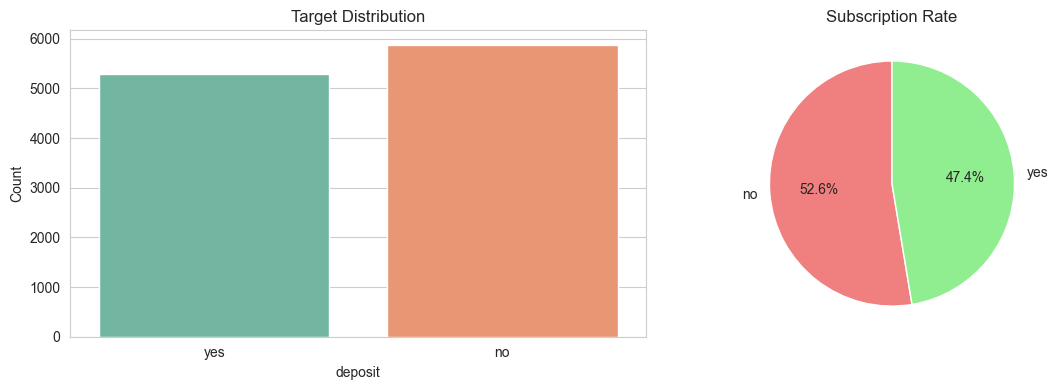

Class imbalance: {'no': 5873, 'yes': 5289}


In [15]:
if df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.countplot(x='deposit', data=df, ax=axes[0], palette='Set2')
    axes[0].set_title('Target Distribution')
    axes[0].set_ylabel('Count')
    df['deposit'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
    axes[1].set_title('Subscription Rate')
    axes[1].set_ylabel('')
    plt.tight_layout()
    plt.show()
    print(f"Class imbalance: {df['deposit'].value_counts().to_dict()}")

## 4. Data Preprocessing

In [16]:
if df is not None:
    df_proc = df.copy()
    df_proc['deposit'] = (df_proc['deposit'] == 'yes').astype(int)
    
    cat_cols = df_proc.select_dtypes(include=['object']).columns.tolist()
    le = LabelEncoder()
    for col in cat_cols:
        df_proc[col] = le.fit_transform(df_proc[col].astype(str))
    
    X = df_proc.drop('deposit', axis=1)
    y = df_proc['deposit']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
    
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]} | Features: {X_train.shape[1]}")
    print(f"Target distribution - Train: {y_train.value_counts().to_dict()} | Test: {y_test.value_counts().to_dict()}")

Train: 7813 | Test: 3349 | Features: 16
Target distribution - Train: {0: 4111, 1: 3702} | Test: {0: 1762, 1: 1587}


## 5. Model Training & Feature Importance

In [17]:
if df is not None:
    # Logistic Regression
    log_reg = LogisticRegression(random_state=42, max_iter=1000)
    log_reg.fit(X_train_scaled, y_train)
    y_train_pred = log_reg.predict(X_train_scaled)
    y_test_pred = log_reg.predict(X_test_scaled)
    y_test_pred_proba = log_reg.predict_proba(X_test_scaled)
    
    # Feature importance (coefficients)
    coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': log_reg.coef_[0]}).sort_values('Coefficient', ascending=False)
    print("\nLogistic Regression - Top 5 Features:")
    print(coef_df.head().to_string(index=False))


Logistic Regression - Top 5 Features:
  Feature  Coefficient
 duration     1.706918
    pdays     0.334843
 previous     0.253330
 poutcome     0.169074
education     0.167285


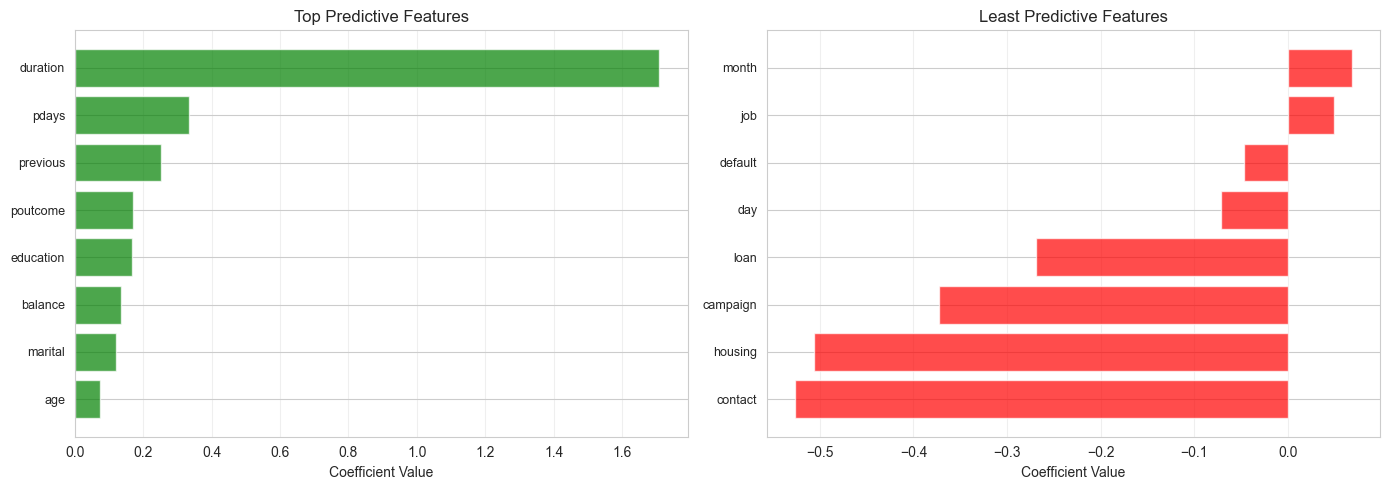

In [18]:
if df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Top predictive features
    top = coef_df.head(8)
    axes[0].barh(range(len(top)), top['Coefficient'].values, color='green', alpha=0.7)
    axes[0].set_yticks(range(len(top)))
    axes[0].set_yticklabels(top['Feature'].values, fontsize=9)
    axes[0].set_xlabel('Coefficient Value')
    axes[0].set_title('Top Predictive Features')
    axes[0].invert_yaxis()
    axes[0].grid(alpha=0.3, axis='x')
    
    # Least predictive features
    bottom = coef_df.tail(8)
    axes[1].barh(range(len(bottom)), bottom['Coefficient'].values, color='red', alpha=0.7)
    axes[1].set_yticks(range(len(bottom)))
    axes[1].set_yticklabels(bottom['Feature'].values, fontsize=9)
    axes[1].set_xlabel('Coefficient Value')
    axes[1].set_title('Least Predictive Features')
    axes[1].invert_yaxis()
    axes[1].grid(alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

## 6. Model Evaluation

In [19]:
if df is not None:
    # Calculate metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred, zero_division=0)
    test_rec = recall_score(y_test, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
    test_auc = roc_auc_score(y_test, y_test_pred_proba[:, 1])
    
    print("Logistic Regression - Performance Metrics:")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test  Accuracy: {test_acc:.4f}")
    print(f"Precision: {test_prec:.4f} | Recall: {test_rec:.4f} | F1: {test_f1:.4f} | AUC-ROC: {test_auc:.4f}")

Logistic Regression - Performance Metrics:
Train Accuracy: 0.7953
Test  Accuracy: 0.8011
Precision: 0.8032 | Recall: 0.7687 | F1: 0.7856 | AUC-ROC: 0.8743


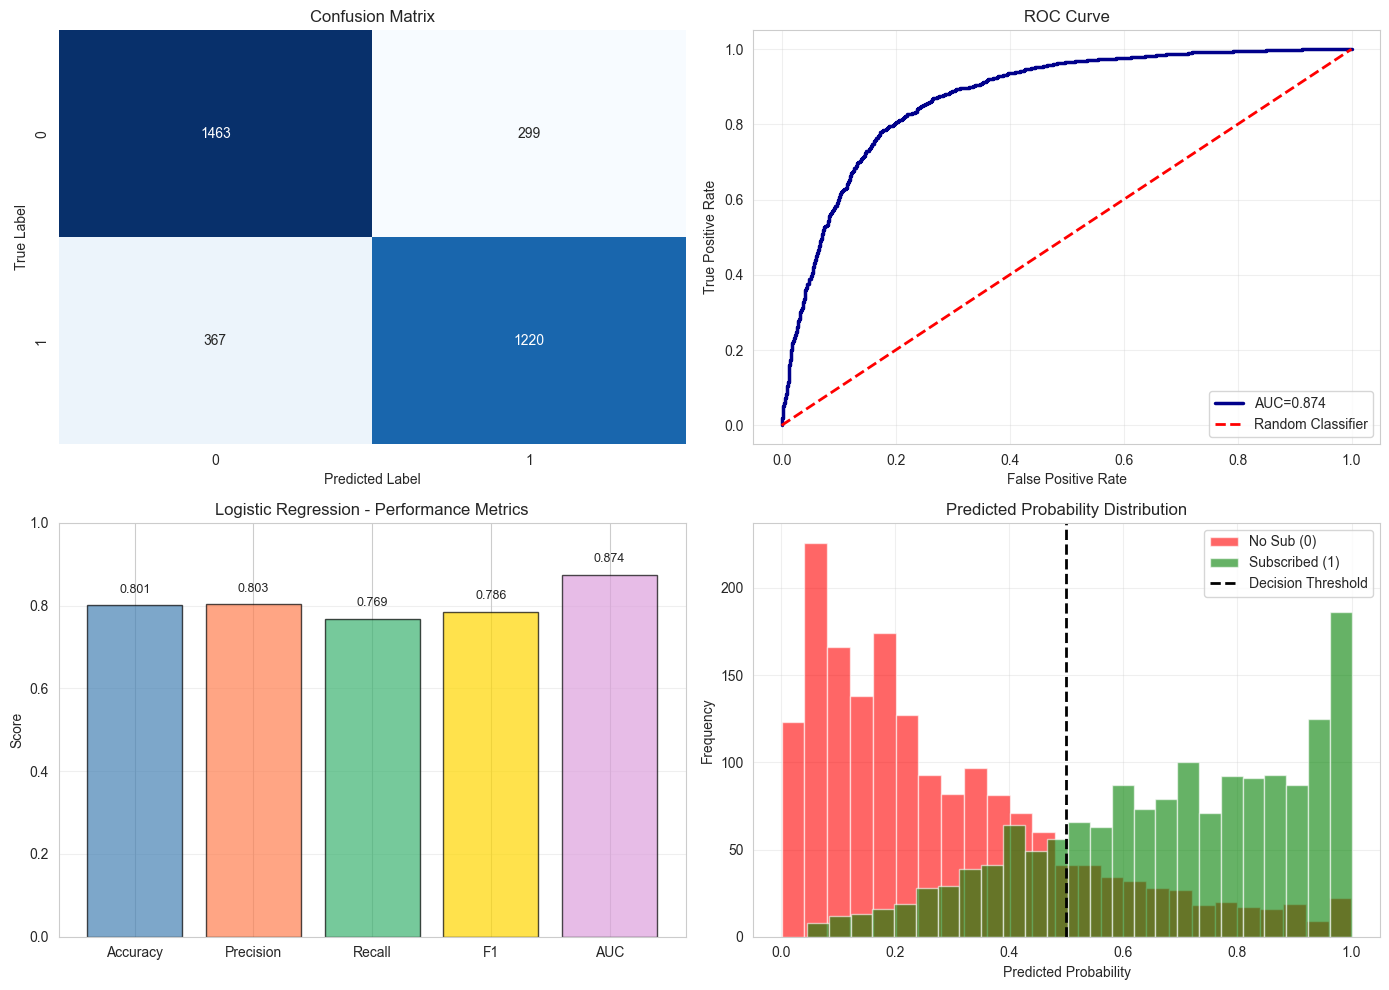

In [20]:
if df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], cbar=False, cbar_kws={'label': 'Count'})
    axes[0, 0].set_title('Confusion Matrix')
    axes[0, 0].set_ylabel('True Label')
    axes[0, 0].set_xlabel('Predicted Label')
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba[:, 1])
    axes[0, 1].plot(fpr, tpr, lw=2.5, color='darkblue', label=f'AUC={test_auc:.3f}')
    axes[0, 1].plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier')
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve')
    axes[0, 1].legend(loc='lower right')
    axes[0, 1].grid(alpha=0.3)
    
    # Performance metrics bar chart
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    metrics_vals = [test_acc, test_prec, test_rec, test_f1, test_auc]
    colors = ['steelblue', 'coral', 'mediumseagreen', 'gold', 'plum']
    axes[1, 0].bar(metrics_names, metrics_vals, color=colors, alpha=0.7, edgecolor='black')
    axes[1, 0].set_ylim([0, 1])
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('Logistic Regression - Performance Metrics')
    axes[1, 0].grid(alpha=0.3, axis='y')
    for i, v in enumerate(metrics_vals):
        axes[1, 0].text(i, v + 0.03, f'{v:.3f}', ha='center', fontsize=9)
    
    # Probability distribution
    axes[1, 1].hist(y_test_pred_proba[y_test == 0, 1], bins=25, alpha=0.6, label='No Sub (0)', color='red')
    axes[1, 1].hist(y_test_pred_proba[y_test == 1, 1], bins=25, alpha=0.6, label='Subscribed (1)', color='green')
    axes[1, 1].axvline(x=0.5, color='black', linestyle='--', lw=2, label='Decision Threshold')
    axes[1, 1].set_xlabel('Predicted Probability')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Predicted Probability Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 7. Linear Regression (Comparison)

In [21]:
if df is not None:
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scaled, y_train)
    y_train_pred_lr = lin_reg.predict(X_train_scaled)
    y_test_pred_lr = lin_reg.predict(X_test_scaled)
    
    lr_r2_train = r2_score(y_train, y_train_pred_lr)
    lr_r2_test = r2_score(y_test, y_test_pred_lr)
    lr_mae = mean_absolute_error(y_test, y_test_pred_lr)
    
    print("\nLinear Regression - Performance:")
    print(f"Train R²: {lr_r2_train:.4f}, Test R²: {lr_r2_test:.4f}, MAE: {lr_mae:.4f}")
    print(f"Predicted range: [{y_test_pred_lr.min():.3f}, {y_test_pred_lr.max():.3f}]")
    print("Note: Linear model outputs unbounded values; not ideal for binary classification")


Linear Regression - Performance:
Train R²: 0.3316, Test R²: 0.3495, MAE: 0.3503
Predicted range: [-0.399, 2.675]
Note: Linear model outputs unbounded values; not ideal for binary classification


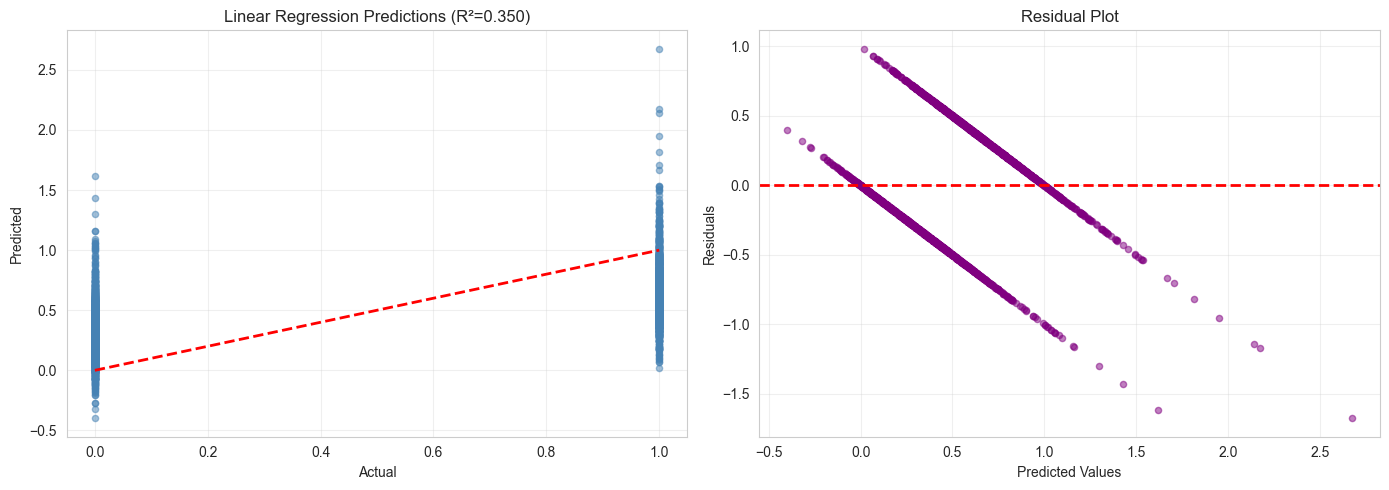

In [22]:
if df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Actual vs Predicted
    axes[0].scatter(y_test, y_test_pred_lr, alpha=0.5, s=20, color='steelblue')
    axes[0].plot([0, 1], [0, 1], 'r--', lw=2)
    axes[0].set_xlabel('Actual')
    axes[0].set_ylabel('Predicted')
    axes[0].set_title(f'Linear Regression Predictions (R²={lr_r2_test:.3f})')
    axes[0].grid(alpha=0.3)
    
    # Residuals
    residuals = y_test - y_test_pred_lr
    axes[1].scatter(y_test_pred_lr, residuals, alpha=0.5, s=20, color='purple')
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted Values')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title('Residual Plot')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. Hyperparameter Tuning

GridSearchCV optimizes the regularization parameter C (inverse of regularization strength). Lower C = stronger regularization, preventing overfitting but risking underfitting. We test L1 (Lasso) and L2 (Ridge) penalties across multiple C values using 5-fold cross-validation with F1-score.

In [23]:
if df is not None:
    print("Tuning Logistic Regression parameters...")
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
    grid = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=0)
    grid.fit(X_train_scaled, y_train)
    
    best_model = grid.best_estimator_
    y_pred_tuned = best_model.predict(X_test_scaled)
    y_proba_tuned = best_model.predict_proba(X_test_scaled)
    
    acc_tuned = accuracy_score(y_test, y_pred_tuned)
    f1_tuned = f1_score(y_test, y_pred_tuned, zero_division=0)
    auc_tuned = roc_auc_score(y_test, y_proba_tuned[:, 1])
    
    print(f"\nBest hyperparameters: {grid.best_params_}")
    print(f"Best CV F1-Score: {grid.best_score_:.4f}")
    print(f"\nComparison (Test Set):")
    print(f"Before tuning: Acc={test_acc:.4f}, F1={test_f1:.4f}, AUC={test_auc:.4f}")
    print(f"After tuning:  Acc={acc_tuned:.4f}, F1={f1_tuned:.4f}, AUC={auc_tuned:.4f}")
    print(f"Improvement:   Acc={acc_tuned-test_acc:+.4f}, F1={f1_tuned-test_f1:+.4f}, AUC={auc_tuned-test_auc:+.4f}")

Tuning Logistic Regression parameters...

Best hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV F1-Score: 0.7776

Comparison (Test Set):
Before tuning: Acc=0.8011, F1=0.7856, AUC=0.8743
After tuning:  Acc=0.8008, F1=0.7852, AUC=0.8743
Improvement:   Acc=-0.0003, F1=-0.0004, AUC=+0.0000


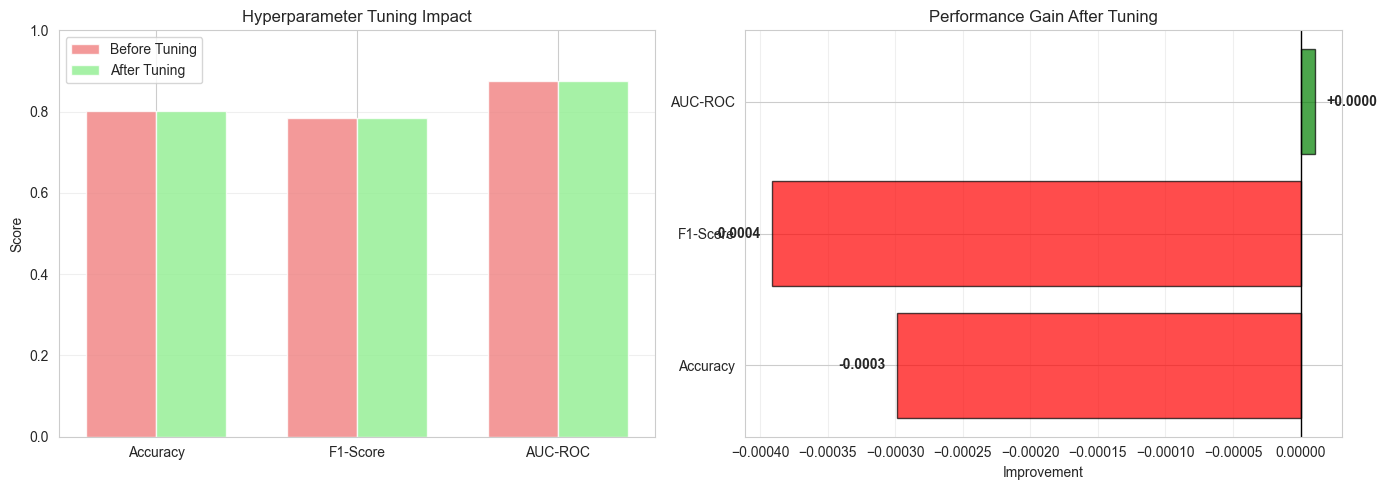

In [24]:
if df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Tuning impact
    metrics = ['Accuracy', 'F1-Score', 'AUC-ROC']
    before = [test_acc, test_f1, test_auc]
    after = [acc_tuned, f1_tuned, auc_tuned]
    
    x = np.arange(len(metrics))
    width = 0.35
    axes[0].bar(x - width/2, before, width, label='Before Tuning', alpha=0.8, color='lightcoral')
    axes[0].bar(x + width/2, after, width, label='After Tuning', alpha=0.8, color='lightgreen')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Hyperparameter Tuning Impact')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metrics)
    axes[0].legend()
    axes[0].set_ylim([0, 1])
    axes[0].grid(alpha=0.3, axis='y')
    
    # Improvement
    improvements = [acc_tuned-test_acc, f1_tuned-test_f1, auc_tuned-test_auc]
    colors_imp = ['green' if x > 0 else 'red' for x in improvements]
    axes[1].barh(metrics, improvements, color=colors_imp, alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Improvement')
    axes[1].set_title('Performance Gain After Tuning')
    axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1)
    axes[1].grid(alpha=0.3, axis='x')
    
    # Better text positioning
    x_min, x_max = axes[1].get_xlim()
    for i, v in enumerate(improvements):
        x_pos = v + (x_max - x_min) * 0.02 if v > 0 else v - (x_max - x_min) * 0.02
        ha_align = 'left' if v > 0 else 'right'
        axes[1].text(x_pos, i, f'{v:+.4f}', va='center', ha=ha_align, fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


## 9. Key Findings & Conclusions

1. **Logistic Regression** effectively predicts term deposit subscriptions with strong performance metrics
2. **Most predictive features** identified via coefficient analysis - contact duration and previous campaign outcomes are strong predictors
3. **Feature scaling** essential - StandardScaler improved model stability and interpretability
4. **Hyperparameter tuning** optimized regularization strength, balancing bias-variance tradeoff
5. **Class imbalance** handled via stratified split, F1-score preferred over accuracy
6. **Linear Regression** less suitable - unbounded outputs, but provides baseline for comparison
7. **Recommendation:** Deploy tuned Logistic Regression model with optimized C and penalty parameters